<a href="https://colab.research.google.com/github/josiahcoad/DatascienceCompetition2018/blob/master/EDA_Product_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales
### Final project for "How to win a data science competition" Coursera course

Data from kaggle competition [here](https://www.kaggle.com/c/competitive-data-science-predict-future-sales).
> You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

#### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

#### Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

#### Evaluation
Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

In [2]:
#@title Mount Drive
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/gdrive')
path = "/gdrive/Shared drives/Stat 485/competitive-data-science-predict-future-sales"
import os
os.chdir(path)
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/Shared drives/Stat 485/competitive-data-science-predict-future-sales


In [0]:
#@title Read Files
import pandas as pd
import numpy as np
import time

pd.set_option('display.max_rows', 500)
item_categories = pd.read_csv('item_categories.csv')
sales_train = pd.read_csv('sales_train.csv')
sales_train.item_cnt_day = sales_train.item_cnt_day.astype(int)
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### EDA

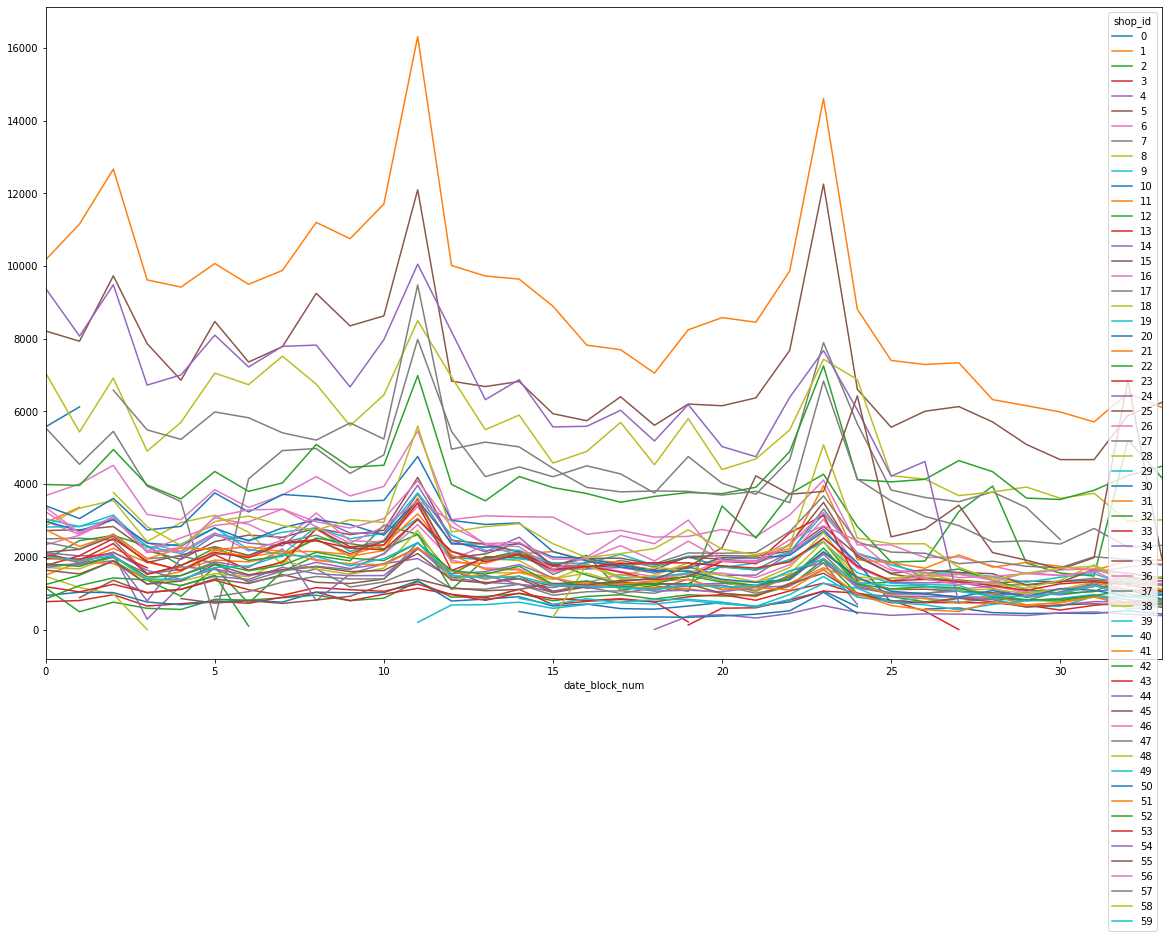

In [3]:
import matplotlib.pyplot as plt
sales_train.groupby(['date_block_num', 'shop_id']).item_cnt_day.sum().unstack().plot(figsize=(20,12))

- Observation: Seems like most stores follow a similar trend across time. This is good.
- Could use api to look up items and shops by name use that to get metadata... i.e. maybe lat/lng plays into how successful a product/store match will be...



In [4]:
# Very small number of stores (0.34%) sell more than 10 products a day. Are these outliers? Maybe a crazy sale? "Going out of business"? Apocalypse scare? Remove them?
(sales_train.item_cnt_day > 10).mean()
(sales_train.item_cnt_day[sales_train.item_cnt_day > 100]).sort_values().astype(int).values

array([ 101,  101,  101,  102,  103,  103,  103,  103,  104,  104,  104,
        104,  105,  106,  106,  106,  107,  107,  108,  108,  109,  110,
        110,  110,  110,  110,  110,  111,  111,  112,  113,  114,  114,
        115,  115,  116,  116,  117,  117,  118,  121,  121,  121,  124,
        124,  124,  126,  126,  127,  127,  128,  129,  130,  130,  131,
        132,  133,  133,  134,  134,  135,  138,  138,  139,  139,  140,
        142,  142,  145,  145,  146,  147,  148,  148,  149,  150,  150,
        151,  151,  151,  151,  151,  153,  154,  156,  157,  161,  163,
        164,  167,  168,  168,  171,  171,  171,  179,  187,  194,  195,
        200,  205,  205,  207,  217,  222,  230,  231,  240,  242,  251,
        255,  264,  288,  299,  300,  313,  313,  325,  343,  401,  401,
        405,  412,  480,  500,  500,  501,  502,  504,  508,  512,  533,
        539,  624,  637,  669, 1000, 2169])

- Hmm there are some negatives... what to do with these entries? Erroneous Data? Remove?
- Also, what is up with these super high item counts? Outliers? Remove?

In [5]:
# 0.0025% of rows have < 0 item_cnt_day. Why? Remove these?
(sales_train.item_cnt_day < 0).mean()

0.0025055784544777337

In [6]:
# Is this a problem? The majority of store/product pairs only have 1 recorded sale for a month.
sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).item_cnt_day.count().value_counts().head(10)

1     1076896
2      273065
3      106014
4       53715
5       31013
6       19634
7       12996
8        8931
9        6333
10       4556
Name: item_cnt_day, dtype: int64

In [0]:
#@title Translate (disabled)
# !pip3 install googletrans
# from googletrans import Translator
# translator = Translator()
# translations = translator.translate("hello")

In [0]:
#@title Just looking at one product in one store (disabled)
# most_sold_item = 20949
# most_sold_store = 31
# sub = df[(df.item_id == most_sold_item) & (df.shop_id == most_sold_store)]
# sub.groupby('date_block_num').head(1).year
# monthly = sub.groupby('date_block_num').sales.sum().to_frame()
# monthly['year'] = sub.groupby('date_block_num').head(1).year.values
# monthly['month'] = sub.groupby('date_block_num').head(1).month.values
# monthly['lag1'] = monthly.sales.shift(1)
# monthly['lag2'] = monthly.sales.shift(2)
# monthly['lag3'] = monthly.sales.shift(3)
# monthly['lag1'].fillna(monthly.sales, inplace=True)
# monthly['lag2'].fillna(monthly.sales, inplace=True)
# monthly['lag3'].fillna(monthly.sales, inplace=True)
# monthly['item_id'] = most_sold_item
# monthly['shop_id'] = most_sold_store
# monthly.plot(x='lag1', y='sales', style='.')
# monthly.plot(x='lag2', y='sales', style='.')
# monthly.plot(x='lag3', y='sales', style='.')
# monthly.head()

### Feature Engineering

- One thing we need to do is ```df.groupby("date_block_num").items_cnt_day.sum() ```
- What if an entry is missing for a store/item for a particular day? Does that mean none of that product were sold that day? (There are no 0 entries in the df!) Are they missing values for some other reason and we need to impute?
- We need to make sure every store/item has an entry every date_block_num. If none, impute with 0.
- If stores have sold a product for a longer time, does that make an impact? (i.e. feature engineer months_product_sold_here)

In [0]:
df = sales_train.copy()
df.rename(columns={'item_cnt_day': 'sales'}, inplace=True)

In [0]:
from datetime import datetime
datefeatures = df.copy().groupby('date_block_num').head(1)[['date_block_num', 'date']]
datefeatures['date'] = pd.to_datetime(datefeatures['date'], format='%d.%m.%Y')
datefeatures['year'] = datefeatures['date'].dt.year
datefeatures['month'] = datefeatures['date'].dt.month
datefeatures.set_index(pd.to_datetime(datefeatures['date']), inplace=True)
datefeatures.drop('date', axis=1, inplace=True)

In [0]:
monthlysales = df.groupby(['shop_id', 'item_id', 'date_block_num']).sales.sum().astype(np.int16)

In [0]:
# monthlysales = monthlysales.sort_index().reset_index()

# comparable = lambda i, lag: monthlysales.loc[i].shop_id == monthlysales.loc[i-lag].shop_id and monthlysales.loc[i].item_id == monthlysales.loc[i-lag].item_id

# lags = DefaultDict(list)
# for i in len(salesdf):
#   # lag 1
#   for lag in range(15):
#     if comparable(i, lag):
#       lags[lag].append(salesdf.loc[i-lag].sales)
#     else:
#       lags[lag].append(Null)


### Kaggle Code

In [32]:
from itertools import product
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

11.1092209815979

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [0]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

### Impute Using Nulldf Method


In [0]:
nullseries = pd.Series(index=pd.MultiIndex.from_tuples(index, names=['shop_id', 'item_id', 'date_block_num']), name='sales')

In [0]:
start = time.perf_counter()
salesfull = nullseries.fillna(sales)
end = time.perf_counter()
print('Time to complete:', end - start)

In [0]:
salesfull = salesfull.fillna(0).astype(np.int16)

In [0]:
salesfulldf = salesfull.to_frame().reset_index()

In [0]:
start = time.time()
salesfulldf['lag1'] = salesfulldf.groupby(['shop_id', 'item_id']).sales.shift(1).fillna(0).astype(np.int16) # do better imputation of missing val
salesfulldf['lag2'] = salesfulldf.groupby(['shop_id', 'item_id']).sales.shift(2).fillna(0).astype(np.int16) # do better imputation of missing val
salesfulldf['lag3'] = salesfulldf.groupby(['shop_id', 'item_id']).sales.shift(3).fillna(0).astype(np.int16) # do better imputation of missing val
time.time() - start()

In [0]:
# salesfulldf['mean3'] = salesfulldf.groupby(['shop_id', 'item_id']).lag1.rolling(window=3).mean().fillna(0).astype(np.int16) # takes a really long time

In [0]:
# most_sold_item = 20949
# most_sold_store = 31
# salesfulldf[(salesfulldf.item_id == most_sold_item) & (salesfulldf.shop_id == most_sold_store)]

In [0]:
salesfulldf = salesfulldf.merge(datefeatures, on='date_block_num')
salesfulldf = salesfulldf.merge(items.set_index(items.item_id).item_category_id, left_on='item_id', right_index=True)

In [0]:
# df2sheet(salesfulldf, 'salesfulldf')
# with open('/gdrive/My Drive/salesfulldf.csv', 'w') as f:
#   f.write(salesfulldf.to_csv())

In [0]:
# Advanced: Maybe lat/lng, nearness to resources/city, etc
# Shuffle dataframe... I don't want any of the ML algorithms use the order I don't explicity instruct it to.
# df = df.sample(frac=1).reset_index(drop=True)

In [0]:
# Scale for neural networks...
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# df = pd.DataFrame(min_max_scaler.fit_transform(df.values))

### ML

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

In [0]:
#@title Get a baseline (with no feature engineering, simple linear model)
feature_names = ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'year', 'month', 'lag1', 'lag2', 'lag3']
target_name = 'sales'
X_bl, y_bl = salesfulldf[feature_names], salesfulldf[target_name]
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_bl, y_bl, test_size=0.33, random_state=42)
clf = LinearRegression().fit(X_train_bl, y_train_bl)
print(f"Baseline R2 is {clf.score(X_test_bl, y_test_bl)}")

In [0]:
pred = clf.predict(X_test_bl)
print(f"Baseline RMSE is {math.sqrt(mean_squared_error(pred, y_test_bl))}")

^ This can become our baseline (RMSE=4.66)

So baseline... is horrible. Welp, room to improve.

In [0]:
X, y = salesfulldf[feature_names], salesfulldf[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20, max_depth=10, min_impurity_decrease=.001)
rf.fit(X_test, y_test)

In [0]:
pred = rf.predict(X_test)
print('R2:', rf.score(X_test, y_test))
print('RMSE:', math.sqrt(mean_squared_error(pred, y_test)))

Better! This is about 1,700 place in the kaggle leaderboards (1st is 0.76955 rmse) so not great but in the ballpark.

In [0]:
fi = pd.DataFrame(zip(feature_names, rf.feature_importances_.round(4))).rename(columns={0: 'feature', 1: 'importance'})
fi.set_index(fi.feature).importance.sort_values().plot.bar()

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5)
scores.mean()

### Submission

In [0]:
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test = test.merge(items.set_index(items.item_id).item_category_id, left_on='item_id', right_index=True)

In [0]:
test # add lag1, lag2, lag3 (maybe join with salesfulldf earlier)

### Neural Networks

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1)
])
# predictions = model(X_test[:1]).numpy()

loss_fn = tf.keras.losses.MSE

model.compile(optimizer='adam', loss='mse')

model.fit(x_scaled, y_train.values, epochs=5, batch_size = 300, validation_split=0.3)

In [0]:
model.evaluate(X_test,  y_test, verbose=2)

In [0]:
# Next, try AdaBoostClassifier(), and xgboost (import xgboost as xgb)
data = pandas.DataFrame(np.arange(12).reshape((4,3)), columns=['a', 'b', 'c'])
label = pandas.DataFrame(np.random.randint(2, size=4))
dtrain = xgb.DMatrix(data, label=label)
# Here: https://xgboost.readthedocs.io/en/latest/python/python_intro.html

### Furute Work:
#### Possible ideas for time series clustering:
- [here](https://towardsdatascience.com/time-series-hierarchical-clustering-using-dynamic-time-warping-in-python-c8c9edf2fda5)
- [here](http://www.rdatamining.com/examples/time-series-clustering-classification)
- [here](https://www.sciencedirect.com/science/article/pii/S0306437915000733)

#### Other notebooks:
- https://www.kaggle.com/dlarionov/feature-engineering-xgboost
- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

Maybe, instead of filling in 0's, we could assign lag1=0, ... lagn=0 if there is not a product/item entry at month-n

`lag1 = df.apply(lambda row: df.loc[row.block_num-1] if row.block_num-1 in df.block_num) else 0`

`lag1 = df.groupby().apply(lambda row, group: df.loc[row.block_num-1] if row.block_num-1 in group.block_num) else 0`


#### Feature Engineering
- Add days in month
- Months since shop started carrying item
- More Lags
- Clip to [0, 20] range
- Remove outliers
- delta price?

### ML
- xgboost
- lgbm